## Training of CIFAR-10 using 110-layer ResNet with constant depth

In [ ]:
import tensorflow as tf
import numpy as np
from utils.neuralnets.ResNet110 import ResNet110
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Input,Flatten,Dense
from tensorflow.keras import Model

In [2]:
##load data and standardize cifar10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train - np.mean(x_train,axis=0))/np.std(x_train,axis=0)
x_test = (x_test - np.mean(x_test,axis=0))/np.std(x_test,axis=0)
##train validation split, 45000 for training and 5000 for validation
np.random.seed(42)
mask_val = np.random.choice(50000,5000,replace=False)
mask_train = np.array([i for i in range(50000) if i not in mask_val])
x_val, y_val = x_train[mask_val], y_train[mask_val]
x_train, y_train = x_train[mask_train], y_train[mask_train]

In [3]:
##data augmentation
##augmented with horizontal flip,random erasing and random shift by 0.1
def randomErasing(x, cut_size=16):
    x = np.copy(x)
    fill = x.mean()

    h, w, _ = x.shape
    top = np.random.randint(0 - cut_size // 2, h - cut_size)
    left = np.random.randint(0 - cut_size // 2, w - cut_size)
    bottom = top + cut_size
    right = left + cut_size
    if top < 0:
        top = 0
    if left < 0:
        left = 0
    x[top:bottom, left:right, :].fill(fill)
    return x
batch_size = 128
datagen_for_train = ImageDataGenerator(horizontal_flip=True,width_shift_range= 0.1, height_shift_range= 0.1
                                       ,preprocessing_function = randomErasing)
datagen_for_test = ImageDataGenerator()
train_data = datagen_for_train.flow(x_train,y_train,batch_size=batch_size)
validation_data = datagen_for_test.flow(x_val, y_val, batch_size=batch_size)

In [4]:
##create a ResNet110 model
input_shape = x_train.shape[1:]
num_class = 10
model = ResNet110(input_shape=input_shape,num_class=num_class)

In [5]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,nesterov=True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


epochs = 200
history = [[],[],[]]
for epoch in range(epochs):
    print("Epoch %d/%d" % (epoch+1,epochs))
    if (epoch==100) | (epoch==150):
        optimizer.learning_rate = optimizer.learning_rate/10
    
    start_time = time.time()
    step = 0
    for x_batch_train, y_batch_train in train_data:
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y_batch_train, logits)
        if step % 25 == 0:
            print(
                "Training loss at step %d: %.4f"
                % (step, float(loss_value))
            )
        step += 1
        if step > len(x_train)/batch_size:
            break

    history[0].append(loss_value.numpy())
    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()
    
    step = 0
    for x_batch_val, y_batch_val in validation_data:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
        step += 1
        if step > len(x_val)/batch_size:
            break
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    history[1].append(train_acc.numpy())
    history[2].append(val_acc.numpy())
    print("Training accuracy: %.4f" % (float(train_acc),)
          ,"Validation accuracy: %.4f" % (float(val_acc),),"Time taken: %.2fs" % (time.time() - start_time))


Epoch 1/200
Training loss at step 0: 9.9470
Training loss at step 25: 6.9868
Training loss at step 50: 3.1300
Training loss at step 75: 2.8975
Training loss at step 100: 2.7906
Training loss at step 125: 2.2324
Training loss at step 150: 2.5272
Training loss at step 175: 2.1978
Training loss at step 200: 2.4153
Training loss at step 225: 2.1671
Training loss at step 250: 1.9893
Training loss at step 275: 2.1555
Training loss at step 300: 1.9511
Training loss at step 325: 2.0011
Training loss at step 350: 1.8480
Training accuracy: 0.1788 Validation accuracy: 0.2406 Time taken: 155.12s
Epoch 2/200
Training loss at step 0: 2.0163
Training loss at step 25: 2.0813
Training loss at step 50: 1.9330
Training loss at step 75: 1.8795
Training loss at step 100: 2.0079
Training loss at step 125: 2.0072
Training loss at step 150: 1.9356
Training loss at step 175: 1.6245
Training loss at step 200: 1.9060
Training loss at step 225: 1.9143
Training loss at step 250: 1.7622
Training loss at step 275: 1

Training accuracy: 0.6457 Validation accuracy: 0.6276 Time taken: 123.22s
Epoch 15/200
Training loss at step 0: 1.0027
Training loss at step 25: 0.9520
Training loss at step 50: 0.8631
Training loss at step 75: 0.9750
Training loss at step 100: 0.9187
Training loss at step 125: 0.9702
Training loss at step 150: 0.9126
Training loss at step 175: 1.1108
Training loss at step 200: 1.0099
Training loss at step 225: 1.1258
Training loss at step 250: 0.8827
Training loss at step 275: 0.8545
Training loss at step 300: 0.8620
Training loss at step 325: 1.0162
Training loss at step 350: 0.9835
Training accuracy: 0.6572 Validation accuracy: 0.6610 Time taken: 123.67s
Epoch 16/200
Training loss at step 0: 1.0963
Training loss at step 25: 0.8843
Training loss at step 50: 0.9002
Training loss at step 75: 0.9264
Training loss at step 100: 1.0090
Training loss at step 125: 0.9188
Training loss at step 150: 1.0734
Training loss at step 175: 0.9363
Training loss at step 200: 0.8411
Training loss at ste

Training loss at step 325: 0.6909
Training loss at step 350: 0.8383
Training accuracy: 0.7454 Validation accuracy: 0.6580 Time taken: 123.51s
Epoch 29/200
Training loss at step 0: 0.8775
Training loss at step 25: 0.6231
Training loss at step 50: 0.6947
Training loss at step 75: 0.6639
Training loss at step 100: 0.5829
Training loss at step 125: 0.6650
Training loss at step 150: 0.7036
Training loss at step 175: 0.7614
Training loss at step 200: 0.6966
Training loss at step 225: 0.8499
Training loss at step 250: 0.9639
Training loss at step 275: 0.6774
Training loss at step 300: 0.6880
Training loss at step 325: 0.5818
Training loss at step 350: 0.8474
Training accuracy: 0.7560 Validation accuracy: 0.7204 Time taken: 123.22s
Epoch 30/200
Training loss at step 0: 0.8281
Training loss at step 25: 0.7259
Training loss at step 50: 0.6267
Training loss at step 75: 0.6735
Training loss at step 100: 0.5457
Training loss at step 125: 0.5954
Training loss at step 150: 0.6937
Training loss at ste

Training loss at step 275: 0.5508
Training loss at step 300: 0.5906
Training loss at step 325: 0.5285
Training loss at step 350: 0.4799
Training accuracy: 0.7974 Validation accuracy: 0.7900 Time taken: 123.39s
Epoch 43/200
Training loss at step 0: 0.5792
Training loss at step 25: 0.5780
Training loss at step 50: 0.5603
Training loss at step 75: 0.5485
Training loss at step 100: 0.5375
Training loss at step 125: 0.5798
Training loss at step 150: 0.7403
Training loss at step 175: 0.6593
Training loss at step 200: 0.6523
Training loss at step 225: 0.6182
Training loss at step 250: 0.7151
Training loss at step 275: 0.6157
Training loss at step 300: 0.5556
Training loss at step 325: 0.5970
Training loss at step 350: 0.5957
Training accuracy: 0.8059 Validation accuracy: 0.5242 Time taken: 122.84s
Epoch 44/200
Training loss at step 0: 0.7988
Training loss at step 25: 0.4398
Training loss at step 50: 0.7304
Training loss at step 75: 0.5070
Training loss at step 100: 0.4193
Training loss at ste

Training loss at step 225: 0.7230
Training loss at step 250: 0.4614
Training loss at step 275: 0.5072
Training loss at step 300: 0.4770
Training loss at step 325: 0.4936
Training loss at step 350: 0.4490
Training accuracy: 0.8315 Validation accuracy: 0.7700 Time taken: 123.83s
Epoch 57/200
Training loss at step 0: 0.4492
Training loss at step 25: 0.4095
Training loss at step 50: 0.4438
Training loss at step 75: 0.4267
Training loss at step 100: 0.4152
Training loss at step 125: 0.6942
Training loss at step 150: 0.5223
Training loss at step 175: 0.4290
Training loss at step 200: 0.5796
Training loss at step 225: 0.5565
Training loss at step 250: 0.4924
Training loss at step 275: 0.3609
Training loss at step 300: 0.3185
Training loss at step 325: 0.5352
Training loss at step 350: 0.5156
Training accuracy: 0.8321 Validation accuracy: 0.8448 Time taken: 123.90s
Epoch 58/200
Training loss at step 0: 0.4409
Training loss at step 25: 0.3972
Training loss at step 50: 0.3276
Training loss at st

Training loss at step 175: 0.5481
Training loss at step 200: 0.3591
Training loss at step 225: 0.3113
Training loss at step 250: 0.4353
Training loss at step 275: 0.3363
Training loss at step 300: 0.3930
Training loss at step 325: 0.4137
Training loss at step 350: 0.4903
Training accuracy: 0.8544 Validation accuracy: 0.8160 Time taken: 123.59s
Epoch 71/200
Training loss at step 0: 0.3306
Training loss at step 25: 0.4765
Training loss at step 50: 0.2773
Training loss at step 75: 0.4236
Training loss at step 100: 0.4184
Training loss at step 125: 0.3682
Training loss at step 150: 0.4277
Training loss at step 175: 0.4749
Training loss at step 200: 0.5512
Training loss at step 225: 0.4058
Training loss at step 250: 0.3070
Training loss at step 275: 0.4021
Training loss at step 300: 0.3555
Training loss at step 325: 0.4198
Training loss at step 350: 0.3219
Training accuracy: 0.8582 Validation accuracy: 0.8618 Time taken: 123.94s
Epoch 72/200
Training loss at step 0: 0.2569
Training loss at 

Training loss at step 125: 0.4337
Training loss at step 150: 0.3871
Training loss at step 175: 0.3432
Training loss at step 200: 0.4616
Training loss at step 225: 0.4974
Training loss at step 250: 0.3433
Training loss at step 275: 0.3286
Training loss at step 300: 0.4016
Training loss at step 325: 0.3037
Training loss at step 350: 0.4942
Training accuracy: 0.8737 Validation accuracy: 0.8462 Time taken: 123.10s
Epoch 85/200
Training loss at step 0: 0.3740
Training loss at step 25: 0.4232
Training loss at step 50: 0.3114
Training loss at step 75: 0.3080
Training loss at step 100: 0.4020
Training loss at step 125: 0.2665
Training loss at step 150: 0.2252
Training loss at step 175: 0.3029
Training loss at step 200: 0.2823
Training loss at step 225: 0.4224
Training loss at step 250: 0.2370
Training loss at step 275: 0.3698
Training loss at step 300: 0.3837
Training loss at step 325: 0.2771
Training loss at step 350: 0.3204
Training accuracy: 0.8743 Validation accuracy: 0.8366 Time taken: 12

Training loss at step 75: 0.3602
Training loss at step 100: 0.3380
Training loss at step 125: 0.2852
Training loss at step 150: 0.3326
Training loss at step 175: 0.3011
Training loss at step 200: 0.3567
Training loss at step 225: 0.3057
Training loss at step 250: 0.3427
Training loss at step 275: 0.2839
Training loss at step 300: 0.3017
Training loss at step 325: 0.3683
Training loss at step 350: 0.2665
Training accuracy: 0.8822 Validation accuracy: 0.8680 Time taken: 122.53s
Epoch 99/200
Training loss at step 0: 0.4819
Training loss at step 25: 0.2401
Training loss at step 50: 0.2118
Training loss at step 75: 0.2973
Training loss at step 100: 0.2434
Training loss at step 125: 0.4667
Training loss at step 150: 0.2613
Training loss at step 175: 0.2237
Training loss at step 200: 0.2818
Training loss at step 225: 0.2980
Training loss at step 250: 0.2882
Training loss at step 275: 0.3754
Training loss at step 300: 0.2266
Training loss at step 325: 0.3324
Training loss at step 350: 0.2372
T

Training loss at step 0: 0.2863
Training loss at step 25: 0.1514
Training loss at step 50: 0.1742
Training loss at step 75: 0.2049
Training loss at step 100: 0.1689
Training loss at step 125: 0.3858
Training loss at step 150: 0.3273
Training loss at step 175: 0.1455
Training loss at step 200: 0.2278
Training loss at step 225: 0.2871
Training loss at step 250: 0.1083
Training loss at step 275: 0.1948
Training loss at step 300: 0.3098
Training loss at step 325: 0.2138
Training loss at step 350: 0.2607
Training accuracy: 0.9172 Validation accuracy: 0.9026 Time taken: 123.82s
Epoch 113/200
Training loss at step 0: 0.1620
Training loss at step 25: 0.1321
Training loss at step 50: 0.1996
Training loss at step 75: 0.1566
Training loss at step 100: 0.2830
Training loss at step 125: 0.2040
Training loss at step 150: 0.2969
Training loss at step 175: 0.1498
Training loss at step 200: 0.1856
Training loss at step 225: 0.2875
Training loss at step 250: 0.2487
Training loss at step 275: 0.3051
Trai

Training accuracy: 0.9206 Validation accuracy: 0.9034 Time taken: 123.75s
Epoch 126/200
Training loss at step 0: 0.1896
Training loss at step 25: 0.2067
Training loss at step 50: 0.2203
Training loss at step 75: 0.2165
Training loss at step 100: 0.1595
Training loss at step 125: 0.2685
Training loss at step 150: 0.2318
Training loss at step 175: 0.3470
Training loss at step 200: 0.2788
Training loss at step 225: 0.2103
Training loss at step 250: 0.1903
Training loss at step 275: 0.1724
Training loss at step 300: 0.2106
Training loss at step 325: 0.1821
Training loss at step 350: 0.2405
Training accuracy: 0.9218 Validation accuracy: 0.9028 Time taken: 123.50s
Epoch 127/200
Training loss at step 0: 0.2087
Training loss at step 25: 0.2159
Training loss at step 50: 0.1227
Training loss at step 75: 0.3170
Training loss at step 100: 0.2676
Training loss at step 125: 0.2272
Training loss at step 150: 0.3702
Training loss at step 175: 0.2834
Training loss at step 200: 0.2327
Training loss at s

Training loss at step 300: 0.2513
Training loss at step 325: 0.2608
Training loss at step 350: 0.2298
Training accuracy: 0.9249 Validation accuracy: 0.9016 Time taken: 122.86s
Epoch 140/200
Training loss at step 0: 0.1192
Training loss at step 25: 0.1678
Training loss at step 50: 0.1607
Training loss at step 75: 0.1722
Training loss at step 100: 0.2209
Training loss at step 125: 0.2652
Training loss at step 150: 0.2152
Training loss at step 175: 0.2265
Training loss at step 200: 0.1201
Training loss at step 225: 0.1142
Training loss at step 250: 0.2159
Training loss at step 275: 0.2706
Training loss at step 300: 0.2957
Training loss at step 325: 0.3149
Training loss at step 350: 0.2540
Training accuracy: 0.9253 Validation accuracy: 0.9014 Time taken: 124.00s
Epoch 141/200
Training loss at step 0: 0.2797
Training loss at step 25: 0.2417
Training loss at step 50: 0.2591
Training loss at step 75: 0.2995
Training loss at step 100: 0.1883
Training loss at step 125: 0.1955
Training loss at s

Training loss at step 225: 0.1473
Training loss at step 250: 0.2534
Training loss at step 275: 0.1313
Training loss at step 300: 0.1977
Training loss at step 325: 0.1227
Training loss at step 350: 0.1883
Training accuracy: 0.9304 Validation accuracy: 0.9028 Time taken: 123.29s
Epoch 154/200
Training loss at step 0: 0.1965
Training loss at step 25: 0.1986
Training loss at step 50: 0.2311
Training loss at step 75: 0.1384
Training loss at step 100: 0.1845
Training loss at step 125: 0.1087
Training loss at step 150: 0.2072
Training loss at step 175: 0.2310
Training loss at step 200: 0.2238
Training loss at step 225: 0.1909
Training loss at step 250: 0.2797
Training loss at step 275: 0.1580
Training loss at step 300: 0.2019
Training loss at step 325: 0.1729
Training loss at step 350: 0.2136
Training accuracy: 0.9280 Validation accuracy: 0.9032 Time taken: 122.81s
Epoch 155/200
Training loss at step 0: 0.2146
Training loss at step 25: 0.1799
Training loss at step 50: 0.2178
Training loss at 

Training loss at step 150: 0.1425
Training loss at step 175: 0.2545
Training loss at step 200: 0.1492
Training loss at step 225: 0.1988
Training loss at step 250: 0.1723
Training loss at step 275: 0.2019
Training loss at step 300: 0.1673
Training loss at step 325: 0.1418
Training loss at step 350: 0.2466
Training accuracy: 0.9312 Validation accuracy: 0.9036 Time taken: 123.25s
Epoch 168/200
Training loss at step 0: 0.1467
Training loss at step 25: 0.2295
Training loss at step 50: 0.1147
Training loss at step 75: 0.1175
Training loss at step 100: 0.2270
Training loss at step 125: 0.1817
Training loss at step 150: 0.1739
Training loss at step 175: 0.1349
Training loss at step 200: 0.2620
Training loss at step 225: 0.1626
Training loss at step 250: 0.1833
Training loss at step 275: 0.1305
Training loss at step 300: 0.1557
Training loss at step 325: 0.1916
Training loss at step 350: 0.1465
Training accuracy: 0.9318 Validation accuracy: 0.9038 Time taken: 123.11s
Epoch 169/200
Training loss

Training loss at step 75: 0.2003
Training loss at step 100: 0.1740
Training loss at step 125: 0.1206
Training loss at step 150: 0.1532
Training loss at step 175: 0.2467
Training loss at step 200: 0.1424
Training loss at step 225: 0.1999
Training loss at step 250: 0.1651
Training loss at step 275: 0.2001
Training loss at step 300: 0.3165
Training loss at step 325: 0.2642
Training loss at step 350: 0.3807
Training accuracy: 0.9306 Validation accuracy: 0.9034 Time taken: 122.82s
Epoch 182/200
Training loss at step 0: 0.1928
Training loss at step 25: 0.1783
Training loss at step 50: 0.1405
Training loss at step 75: 0.2273
Training loss at step 100: 0.1850
Training loss at step 125: 0.2538
Training loss at step 150: 0.1079
Training loss at step 175: 0.1790
Training loss at step 200: 0.1610
Training loss at step 225: 0.2034
Training loss at step 250: 0.1678
Training loss at step 275: 0.4704
Training loss at step 300: 0.1599
Training loss at step 325: 0.3094
Training loss at step 350: 0.1433


Training loss at step 0: 0.1481
Training loss at step 25: 0.1522
Training loss at step 50: 0.1843
Training loss at step 75: 0.1958
Training loss at step 100: 0.2150
Training loss at step 125: 0.2805
Training loss at step 150: 0.1846
Training loss at step 175: 0.1973
Training loss at step 200: 0.1631
Training loss at step 225: 0.2143
Training loss at step 250: 0.1023
Training loss at step 275: 0.1628
Training loss at step 300: 0.2146
Training loss at step 325: 0.2324
Training loss at step 350: 0.2088
Training accuracy: 0.9311 Validation accuracy: 0.9046 Time taken: 123.98s
Epoch 196/200
Training loss at step 0: 0.2120
Training loss at step 25: 0.2208
Training loss at step 50: 0.2005
Training loss at step 75: 0.2160
Training loss at step 100: 0.1932
Training loss at step 125: 0.3035
Training loss at step 150: 0.2412
Training loss at step 175: 0.2233
Training loss at step 200: 0.1878
Training loss at step 225: 0.2819
Training loss at step 250: 0.1573
Training loss at step 275: 0.2567
Trai

In [4]:
# log = np.array(history)
# np.save("./Logs/ResNet110_cifar10",log)

In [2]:
with open('./Logs/ResNet110_cifar10.npy', 'rb') as f:
     log = np.load(f)

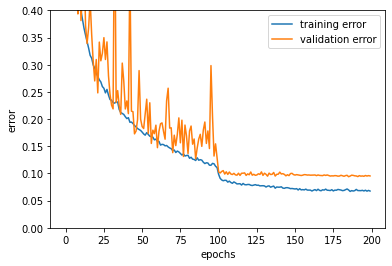

In [12]:
import matplotlib.pyplot as plt
plt.plot(1-log[1],label='training error')
plt.plot(1-log[2],label='validation error')
plt.ylim(0,0.4)
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()